In [1]:
import pandas as pd
import DataLoading
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset
import matplotlib.pyplot as plt

In [2]:
def load_data_ext_out(folder,executions,period,sc,il_os = None):
    dfs_in = dict()
    dfs_out = dict()
    dfs_inter = dict()
    for execution in executions:
        # Read the data from desired execution
        df_in_e = pd.read_csv(f"{folder}/input_f_{sc}_{execution}_{period}.csv", header=[0],index_col=0)
        df_out_e = pd.read_csv(f"{folder}/output_f_{sc}_{execution}_{period}_SystemCosts.csv", header=[0],index_col=0)
        
        print(f"input_f_{sc}_{execution}_{period}.csv")

        # And order the variables:

        print(len(df_in_e.columns))
        for col in df_out_e.columns:
            df_out_e[col] = df_out_e[col].astype(float)
        for col in df_in_e.columns:
            df_in_e[col] = df_in_e[col].astype(float)

        
        if il_os != None:
            dfs_ilo = dict()
            for il_o in il_os:
                df_inter = pd.read_csv(f"{folder}/output_f_{sc}_{execution}_{period}_{il_o}.csv", header=[0],index_col=0)
                for col in df_inter.columns:
                    df_inter[col] = df_inter[col].astype(float)
                dfs_ilo[il_o]=df_inter
            dfs_inter[execution] = dfs_ilo
        
        dfs_in[execution] = df_in_e
        dfs_out[execution] = df_out_e
        
    return dfs_in,dfs_out,dfs_inter

In [3]:
def split_tr_val_te_ext_out(dfs_in,dfs_out,dfs_inter_j,executions,te_s,val_s):
    ts_in = dict()
    ts_out = dict()
    ts_inter = dict()

    ts_in["train"] = dict()
    ts_in["test"] = dict()
    ts_in["val"] = dict()

    ts_out["train"] = dict()
    ts_out["test"] = dict()
    ts_out["val"] = dict()
    
    ts_inter["train"] = dict()
    ts_inter["test"] = dict()
    ts_inter["val"] = dict()

    # Test size as fraction of full dataset, validation size as fraction of training data set
    test_size, validation_size = te_s, val_s
    
    for execution in executions:
        
        # Convert input dataframes numpy arrays sum the columns of the output:
        np_in = dfs_in[execution].to_numpy()
        np_out = dfs_out[execution].to_numpy().sum(axis=1)
        np_inter = dfs_inter_j[execution].to_numpy()        
                                  
        # We don't normalize the separate runs, but will do it afterward, all together

        # Convert to torch tensors
        t_in = torch.from_numpy(np_in)
        t_out = torch.from_numpy(np_out)
        t_inter = torch.from_numpy(np_inter)

        # And split into train, validation, and test set:
        train_in, ts_in["test"][execution], train_out, ts_out["test"][execution],train_inter,ts_inter["test"][execution] = train_test_split(t_in, t_out,t_inter,
                                                                                                    test_size=test_size,
                                                                                                    shuffle=False)
        ts_in["train"][execution], ts_in["val"][execution], ts_out["train"][execution], ts_out["val"][
            execution],ts_inter["train"][execution], ts_inter["val"][
            execution] = train_test_split(train_in, train_out,train_inter, test_size=validation_size, shuffle=False)
    return ts_in,ts_out,ts_inter


In [4]:
def concat_and_normalize_ext_out(ts_in,ts_out,ts_inter,executions):
    # concatenate all the training and testing sets to a single tensor, and normalize:
    first = True
    for execution in executions:
        if first:
            tr_in = ts_in["train"][execution]
            tr_out = ts_out["train"][execution]
            tr_inter = ts_inter["train"][execution]
            
            te_in = ts_in["test"][execution]
            te_out = ts_out["test"][execution]
            te_inter = ts_inter["test"][execution]
            
            val_in = ts_in["val"][execution]
            val_out = ts_out["val"][execution]
            val_inter = ts_inter["val"][execution]
            first = False
        else:
            tr_in = torch.cat((tr_in, ts_in["train"][execution]))
            tr_out = torch.cat((tr_out, ts_out["train"][execution]))
            tr_inter = torch.cat((tr_inter, ts_inter["train"][execution]))

            
            te_in = torch.cat((te_in, ts_in["test"][execution]))
            te_out = torch.cat((te_out, ts_out["test"][execution]))
            te_inter = torch.cat((te_inter, ts_inter["test"][execution]))
            
            val_in = torch.cat((val_in, ts_in["val"][execution]))
            val_out = torch.cat((val_out, ts_out["val"][execution]))
            val_inter = torch.cat((val_inter, ts_inter["val"][execution]))
            
    maxs=dict()
    maxs["in"] = torch.cat((tr_in, te_in, val_in)).abs().max(dim=0).values
    maxs["inter"] = torch.cat((tr_inter, te_inter, val_inter)).abs().max(dim=0).values
    # maxs_te = te_in.abs().max(dim = 0).values
    
    tr_in = torch.nan_to_num(tr_in / maxs["in"])
    te_in = torch.nan_to_num(te_in / maxs["in"])
    val_in = torch.nan_to_num(val_in / maxs["in"])
    
    tr_inter = torch.nan_to_num(tr_inter / maxs["inter"])
    te_inter = torch.nan_to_num(te_inter / maxs["inter"])
    val_inter = torch.nan_to_num(val_inter / maxs["inter"])

    d_ft_in = {"train": tr_in,"val": val_in,"test": te_in}
    d_ft_out = {"train": tr_out,"val": val_out,"test": te_out}
    d_ft_inter = {"train": tr_inter,"val": val_inter,"test": te_inter}


    return d_ft_in,d_ft_out,d_ft_inter


In [5]:
def join_frames_inter_layer(dfs_inter):
    dfs_inter_j = dict()
    for execution in dfs_inter.keys(): 
        dfs_inter_j[execution] = pd.concat([dfs_inter[execution][t] for t in dfs_inter[execution].keys()],axis=1)
    return dfs_inter_j

In [6]:
class ObjectiveEstimator_ANN_1hidden_layer_inter(torch.nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_ratio=0.0,relu_out = False ):
        super().__init__()
        hidden_size1 = hidden_sizes[0]
        print(hidden_size1)
        print(output_size)
        self.hidden_layer1 = torch.nn.Linear(input_size, hidden_size1)
        self.dropout = torch.nn.Dropout(dropout_ratio)
        self.output_layer = torch.nn.Linear(hidden_size1, output_size)
        self.relu_out = relu_out

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def forward(self, input):
        hidden1 = torch.relu(self.hidden_layer1(input))
        hidden1_dropout = self.dropout(hidden1)
        if (self.relu_out):
            output = torch.relu(self.output_layer(hidden1_dropout))
        else:
            output = self.output_layer(hidden1_dropout)
        return output,hidden1

In [38]:
import torch.nn.functional as F

def custom_loss(output, target_output, hidden_layer_representation, target_hidden, alpha=1.0):
    # Compute the standard loss (e.g., mean squared error) for the output layer
    standard_loss = F.mse_loss(output.squeeze(), target_output)

    # Compute a loss term based on the hidden layer representation and its target
    hidden_loss = F.mse_loss(hidden_layer_representation, target_hidden)

    # Combine the two loss terms with a weighting factor alpha
    total_loss = standard_loss + alpha * hidden_loss

    return total_loss



In [8]:
executions = ["Network_Existing_Generation_Full"]

sc = "sc01"
period = "2030"
folder = "../Data/RTS24_AC_12w_ext_o"
te_s = 0.1
val_s = 0.2

dfs_in,dfs_out,dfs_inter = load_data_ext_out(folder,executions,period,sc,["PowerOutput","PowerFlow"])
dfs_inter_j = join_frames_inter_layer(dfs_inter)
ts_in,ts_out,ts_inter = split_tr_val_te_ext_out(dfs_in,dfs_out,dfs_inter_j,executions,te_s,val_s)
d_ft_in, d_ft_out,d_ft_inter = concat_and_normalize_ext_out(ts_in,ts_out,ts_inter,executions)


input_f_sc01_Network_Existing_Generation_Full_2030.csv
1203


In [64]:
train = TensorDataset(d_ft_in['train'].float(), d_ft_out['train'].float(),d_ft_inter['train'])
validation = TensorDataset(d_ft_in['val'].float(), d_ft_out['val'].float(),d_ft_inter['val'].float())

training_loader = DataLoader(train,batch_size=32)
#validation_loader = DataLoader(validation,batch_size=64)

num_epochs = 100
learning_rate = 0.001
inp_size = train.tensors[0].shape[1]
inter_size = train.tensors[2].shape[1]
output_size = 1

In [65]:
criterion = custom_loss  # Use your custom loss function

model = ObjectiveEstimator_ANN_1hidden_layer_inter(inp_size,[inter_size],output_size)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


for epoch in range(num_epochs):
    for inputs, targets, target_hidden in training_loader:
        optimizer.zero_grad()
        outputs, hidden_representation = model(inputs)
        loss = criterion(outputs.float(), targets.float(), hidden_representation.float(), target_hidden.float(),alpha = 0.0)
        loss.backward()
        optimizer.step()
    print(loss)

89
1
tensor(3.8697, grad_fn=<AddBackward0>)
tensor(0.1489, grad_fn=<AddBackward0>)
tensor(0.0250, grad_fn=<AddBackward0>)
tensor(0.0071, grad_fn=<AddBackward0>)
tensor(0.0017, grad_fn=<AddBackward0>)
tensor(0.0034, grad_fn=<AddBackward0>)
tensor(0.0085, grad_fn=<AddBackward0>)
tensor(0.0139, grad_fn=<AddBackward0>)
tensor(0.0178, grad_fn=<AddBackward0>)
tensor(0.0201, grad_fn=<AddBackward0>)
tensor(0.0207, grad_fn=<AddBackward0>)
tensor(0.0201, grad_fn=<AddBackward0>)
tensor(0.0187, grad_fn=<AddBackward0>)
tensor(0.0166, grad_fn=<AddBackward0>)
tensor(0.0143, grad_fn=<AddBackward0>)
tensor(0.0119, grad_fn=<AddBackward0>)
tensor(0.0097, grad_fn=<AddBackward0>)
tensor(0.0079, grad_fn=<AddBackward0>)
tensor(0.0064, grad_fn=<AddBackward0>)
tensor(0.0052, grad_fn=<AddBackward0>)
tensor(0.0043, grad_fn=<AddBackward0>)
tensor(0.0037, grad_fn=<AddBackward0>)
tensor(0.0032, grad_fn=<AddBackward0>)
tensor(0.0028, grad_fn=<AddBackward0>)
tensor(0.0025, grad_fn=<AddBackward0>)
tensor(0.0023, grad_

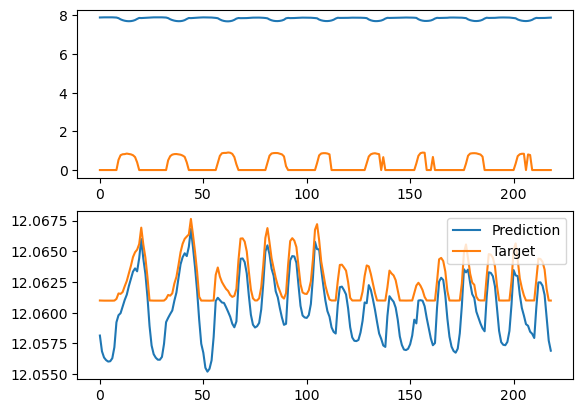

In [67]:
#Inspection of test results:
s = "test"
ex = "Network_Existing_Generation_Full"
costs_target,power_target = d_ft_out[s],d_ft_inter[s]
costs_pred,power_pred = model(d_ft_in[s].float())
i=4
s=0
e=s+500

fig,axs = plt.subplots(2,1)
axs[0].plot(power_pred[s:e,i].detach(),label = "Prediction")
axs[0].plot(power_target[s:e,i],label = "Target")

axs[1].plot(costs_pred[s:e].detach(),label = "Prediction")
axs[1].plot(costs_target[s:e],label = "Target")
plt.legend()

In [45]:
power_target

tensor([12.0610, 12.0610, 12.0610,  ..., 12.0703, 12.0717, 12.0729],
       dtype=torch.float64)

In [85]:
ts_in,ts_out =  DataLoading.split_tr_val_te(dfs_in,dfs_out,executions,te_s,val_s)
ts_in_2,ts_out_2,ts_inter = split_tr_val_te_ext_out(dfs_in,dfs_out,dfs_inter_j,executions,te_s,val_s)

In [61]:
key = "val"
key2 = "Network_Existing_Generation_Full"
for key in ["train", "test","val"]:
    print(key,"in", torch.equal(ts_in[key][key2],ts_in_2[key][key2]))
    print(key,"out", torch.equal(ts_out[key][key2],ts_out_2[key][key2]))

train in True
train out True
test in True
test out True
val in True
val out True


In [75]:
ts_inter["train"]["Network_Existing_Generation_Full"].shape,ts_out["train"]["Network_Existing_Generation_Full"].shape,ts_in["train"]["Network_Existing_Generation_Full"].shape

(torch.Size([1572, 89]), torch.Size([1572]), torch.Size([1572, 1203]))

In [45]:
ts_in["train"].keys()

dict_keys(['Network_Existing_Generation_Full'])